This is my first project using linear regression and later have used other 
machine algs like Random forest Regressor , etc . for better accuracy.

I have taken a reference from #SahilChachra
 
link --- @SahilChachra/Medical-Cost-Prediction
Predict your Medical insurance cost!

# from the below block onwards we are doing the following steps :

1.Exploring dataset

2.Converting Categorical values into Numerical

3.Ploting Heatmap to see the Dependency of Dependant vales on Independant attributes

4.Data Visualization (plots of feature vs feature)

5.Plotting skew and kurtosis  

6.Data Preparation 

7 . Predicting Using Linear Regression 

8. Predicting using Random forest Regressor 

9 . predicting using Ridge Regression 

10 .Performing Hyper tuning for above methods 

11 .Model deployment using django .



# Step 1 Let’s begin by loading the dataset and exploring the attributes (EDA — Exploratory Data Analysis)

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import StandardScaler
from sklearn.impute import  SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
import pickle




file ='insurance.csv'

dataset = pd.read_csv(file)

dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
#check the null values count
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
print (dataset.shape)

display(dataset.describe())
display(dataset.describe(include=['O']))

(1338, 7)


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


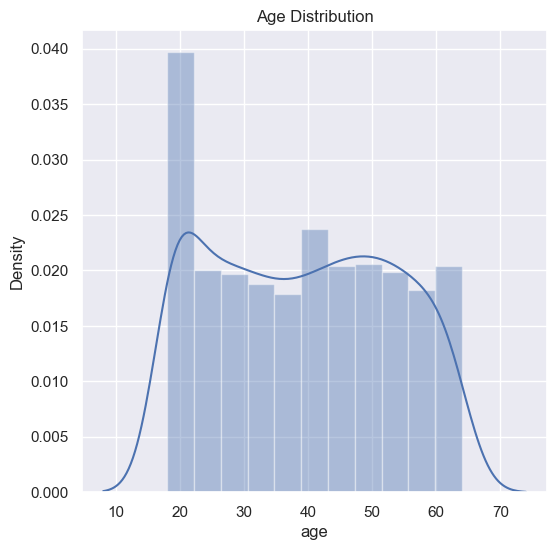

In [7]:
# distribution of age value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(dataset['age'])
plt.title('Age Distribution')
plt.show()

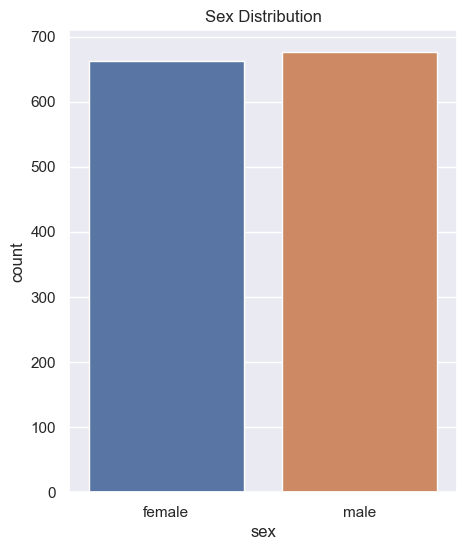

In [27]:
# Gender column
plt.figure(figsize=(5,6))
sns.countplot(x='sex', data=dataset)
plt.title('Sex Distribution')
plt.show()


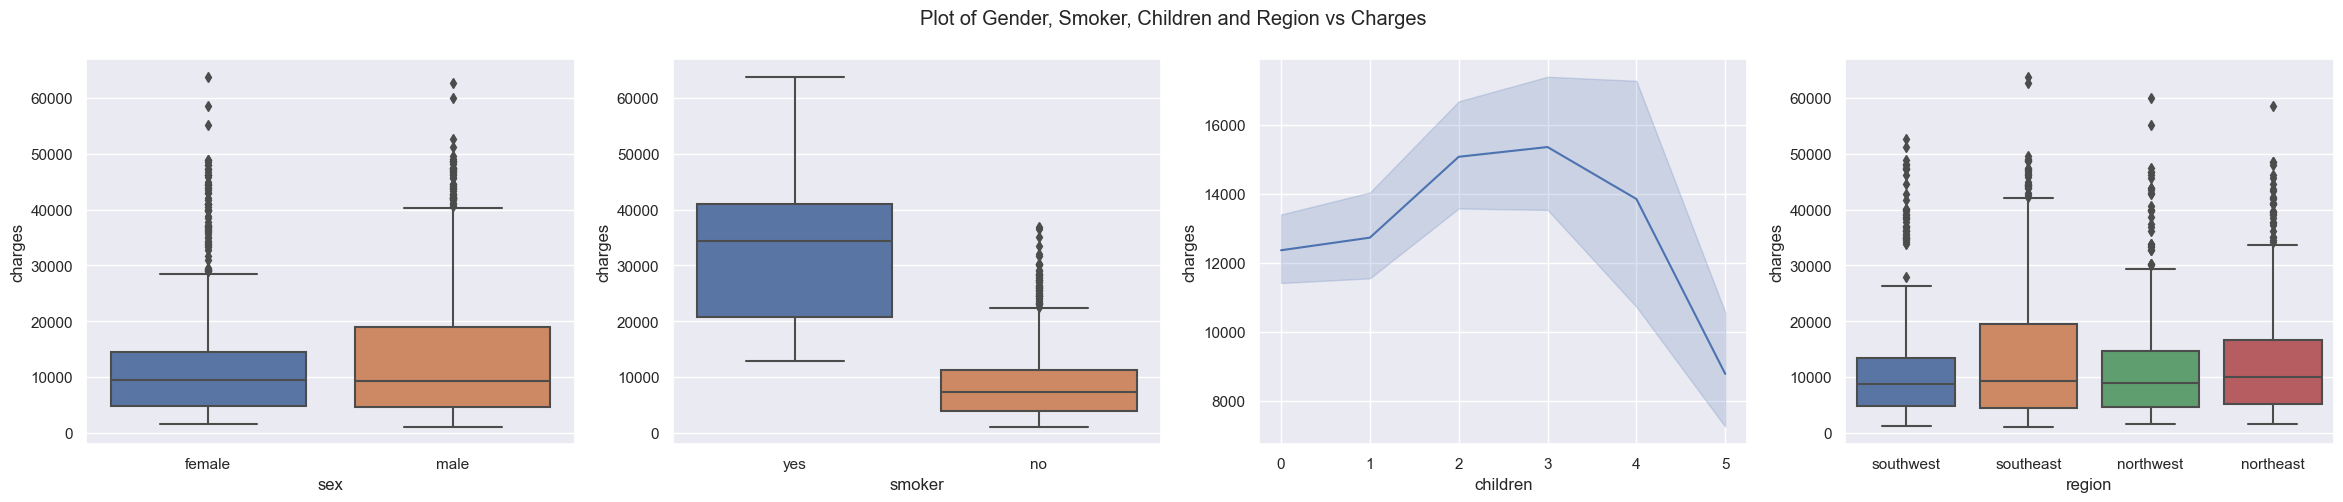

In [23]:
fig, ax2 = plt.subplots(1,4,  figsize=(29,5))
fig.suptitle('Plot of Gender, Smoker, Children and Region vs Charges',)
sns.boxplot(ax=ax2[0], x=dataset.sex, y=dataset.charges)
sns.boxplot(ax=ax2[1], x=dataset.smoker, y=dataset.charges)
sns.lineplot(ax=ax2[2], x=dataset.children, y=dataset.charges)
sns.boxplot(ax=ax2[3], x=dataset.region, y=dataset.charges)
plt.show()



In [30]:
dataset['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

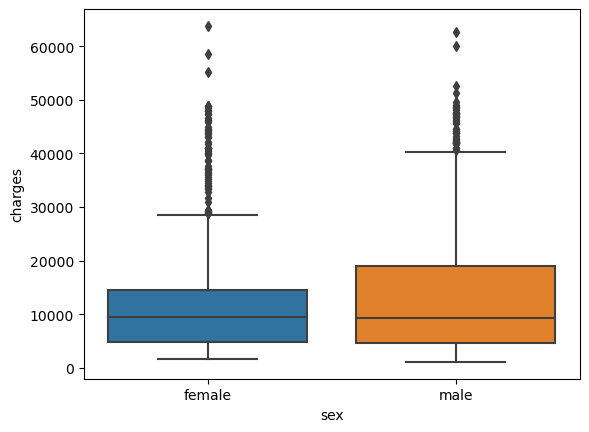

In [24]:
#Box Plot for Gender vs  charges
sns.boxplot(x=dataset.sex, y=dataset.charges)
plt.show()

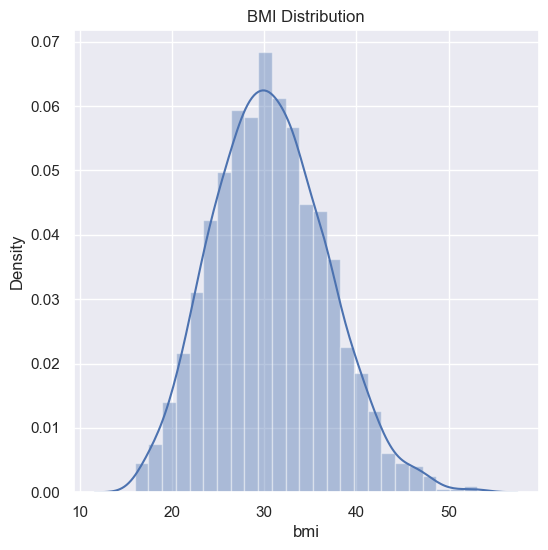

In [32]:
# bmi distribution
plt.figure(figsize=(6,6))
sns.distplot(dataset['bmi'])
plt.title('BMI Distribution')
plt.show()

Most of the people do not have children



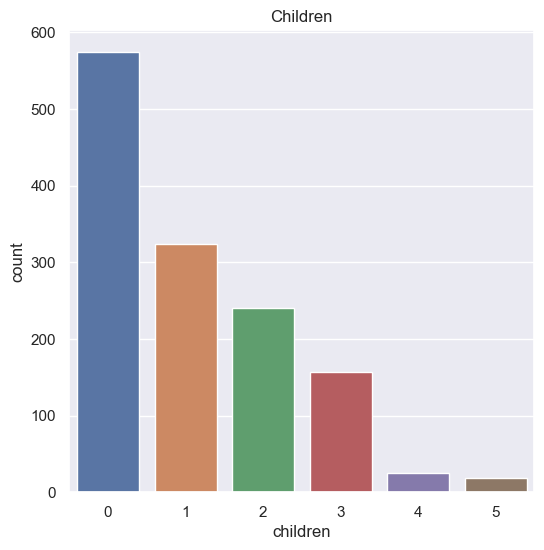

In [34]:
# children column
plt.figure(figsize=(6,6))
sns.countplot(x='children', data=dataset)
plt.title('Children')
plt.show()

In [38]:
dataset['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

Charges are highest for people with 2-3 children

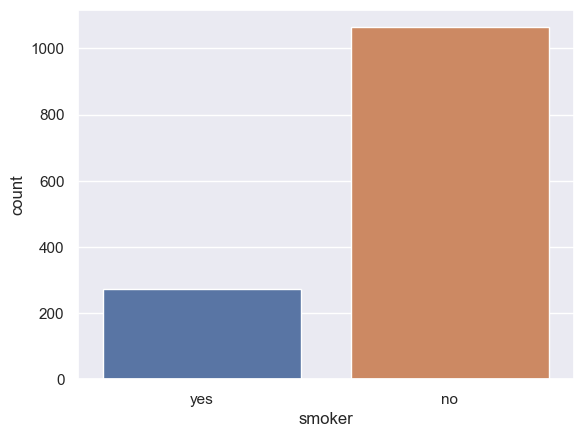

In [36]:
sns.countplot(x= 'smoker' , data = dataset)
plt.show()

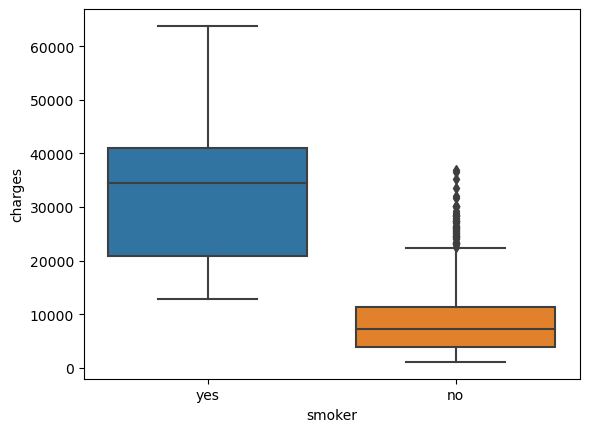

In [49]:
sns.boxplot(x=dataset.smoker, y=dataset.charges)
plt.show()

Percentage of smokers is less but insurance charges are relatively higher for them

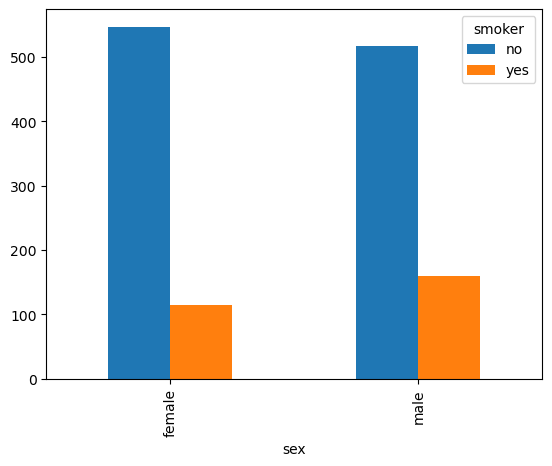

Percentage of female smokers is less than the percentage of male smokers

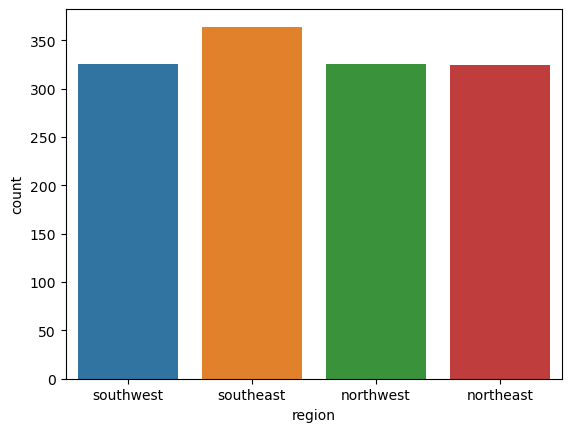

In [56]:
sns.countplot(x='region',data = dataset )
plt.show()

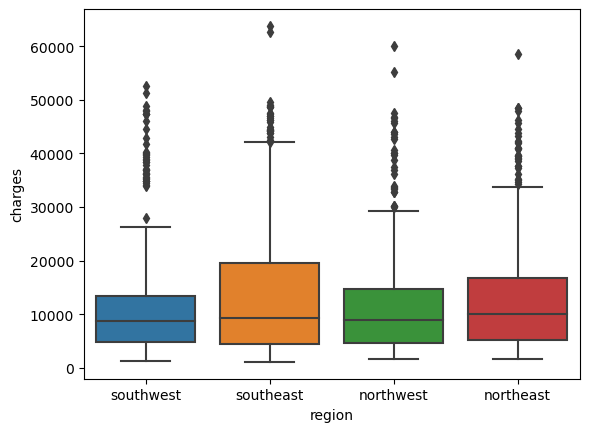

In [58]:
sns.boxplot(x=dataset.region, y=dataset.charges)
plt.show()

Regions are equally distributed and all 4 regions have almost the same charges.

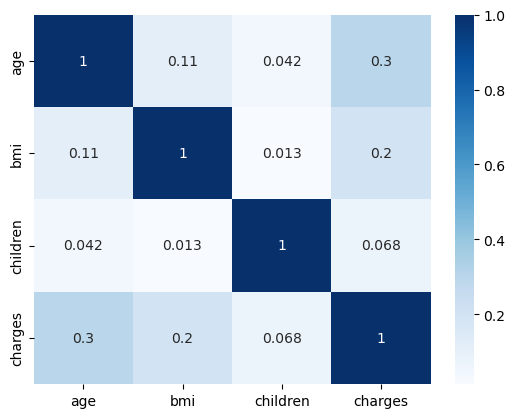

In [8]:
#Correlation map between charges and numeric features - age, bmi and charges
sns.heatmap(dataset[['age', 'bmi', 'children', 'charges']].corr(), cmap='Blues', annot=True)
plt.show()

In [11]:
#Converting categorical variables to numeric form - One hot encoding
region=pd.get_dummies(dataset.region, prefix='location')
dataset = pd.concat([dataset,region],axis=1)
dataset.drop(columns='region', inplace=True)


# #another mtethod
# # encoding sex column
# dataset.replace({'sex':{'male':0,'female':1}}, inplace=True)

# 3 # encoding 'smoker' column
# dataset.replace({'smoker':{'yes':0,'no':1}}, inplace=True)

# # encoding 'region' column
# dataset.replace({'region':{'southeast':0,'southwest':1,'northeast':2,'northwest':3}}, inplace=True)

In [12]:
dataset.sex.replace(to_replace=['male', 'female'], value=[1,0], inplace=True)
dataset.smoker.replace(to_replace=['yes', 'no'], value=[1,0], inplace=True)
dataset.sample(3)

,age,sex,bmi,children,smoker,charges,location_northeast,location_northwest,location_southeast,location_southwest
626,36,1,28.880,3,0,6748.59120,1,0,0,0
471,18,0,30.115,0,0,2203.47185,1,0,0,0
1051,64,1,26.410,0,0,14394.55790,1,0,0,0


Based on the map,
Smoker has a considerable impact on the insurance charges, while sex has the least impact and so we will drop this column in our feature list(X). We will now proceed towards model development 
where the first step is to select X and Y and split data into test and train sets

In [15]:
#Creating and X and Y variables region_rank
X = dataset.drop(columns='charges', axis=1)
y = dataset['charges']

#Split data into test and train
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [18]:
# from sklearn.preprocessing import RobustScaler, StandardScaler
numeric=['age', 'bmi', 'children']
sc=StandardScaler()
X_train[numeric]=sc.fit_transform(X_train[numeric])
X_test[numeric]=sc.transform(X_test[numeric])

Model Development
We will run a number of regression algorithms and evaluate root mean squared error , 
mean absolute error metrics for each of these models. These would be our baseline models.

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))

(0.7835929767120722, 4181.194473753654, 5796.284659276275)

In [28]:
# lets us train the model with more accuracy using Decition trees and RAndom tree regresstion

from sklearn.tree import DecisionTreeRegressor
regressor1 = DecisionTreeRegressor()

# Fit the regressor to your training data
regressor1.fit(X_train, y_train)

# Predict using the trained model
y_pred = regressor1.predict(X_test)

r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))

(0.7574856440759314, 2844.001072261194, 6135.963341298259)

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Create an instance of the RandomForestRegressor
regressor2 = RandomForestRegressor()

# Fit the regressor to your training data
regressor2.fit(X_train, y_train)

# Predict using the trained model
y_pred = regressor2.predict(X_test)
r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))

(0.8628906443783502, 2507.68444588209, 4613.681126380061)

In [107]:
print(r2_score(y_test, y_pred))

0.8652980732569394


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Create an instance of the RandomForestRegressor
regressor = RandomForestRegressor()

# Define the hyperparameters to tune
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=parameters, cv=5)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Hyperparameters:  {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score:  0.8462365193172205


In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Create an instance of the RandomForestRegressor
regressor = RandomForestRegressor()

# Define the hyperparameters to tune
parameters = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 5, 10],
    'min_samples_split': randint(2, 10)
}

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=regressor, param_distributions=parameters, n_iter=10, cv=5)

# Fit the model using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


Best Hyperparameters:  {'max_depth': 5, 'min_samples_split': 9, 'n_estimators': 191}
Best Score:  0.8458698921098666


In [115]:

from joblib import dump

# Save the model to a file
dump(regressor2, 'reg_model.joblib')


['reg_model.joblib']